# RATIO 2019 - Benchmarking Workshop

In [1]:
%load_ext autoreload
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 

In [2]:
import pandas as pd
import csv
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
from sklearn.model_selection import train_test_split
import nltk
nltk.download('wordnet')
def get_train_test_sets(df):
    X = df[['argument1', 'argument2', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)
    return X_train, X_test, y_train, y_test

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Task 1 - Same Side Clasiification



In [4]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [5]:
cross_traindev_df = pd.read_csv(data_cross_path.format('training'), 
                                quotechar='"',quoting=csv.QUOTE_ALL,encoding='utf-8',escapechar='\\',doublequote=False,  index_col='id')
cross_test_df =  pd.read_csv(data_cross_path.format('test'), encoding='utf-8',index_col='id')


within_traindev_df =  pd.read_csv(data_within_path.format('training'), 
                                quotechar='"',quoting=csv.QUOTE_ALL,encoding='utf-8',escapechar='\\',doublequote=False, index_col='id')

within_test_df =  pd.read_csv(data_within_path.format('test'), encoding='utf-8',index_col='id')

In [6]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if title.find('abortion') > -1 :
        row['tag'] = 'abortion'
    elif title.find('gay marriage') > -1 :
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row

cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
cross_test_df = cross_test_df.apply(add_tag, axis=1)

within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
within_test_df = within_test_df.apply(add_tag, axis=1)



In [7]:
print('within train df:', len(within_traindev_df))
print('cross train df:', len(cross_traindev_df))

within train df: 63903
cross train df: 61048


In [8]:
print('within test df:', len(within_test_df))
print('cross test df:', len(cross_test_df))

within test df: 31475
cross test df: 6163


In [9]:
cross_traindev_df.head(n=20)

,argument1,argument1_id,argument2,argument2_id,debate_id,is_same_side,topic,tag
id,,,,,,,,
0,there are two reasons why this debate should g...,100c174f-2019-04-18T17:33:51Z-00000-000,i will give my opponent a chance to respond.,100c174f-2019-04-18T17:33:51Z-00000-000,100c174f-2019-04-18T17:33:51Z,True,abortion should be illegal with exceptions,abortion
1,there are two reasons why this debate should g...,100c174f-2019-04-18T17:33:51Z-00000-000,"in this debate, there are a few factors that m...",100c174f-2019-04-18T17:33:51Z-00000-000,100c174f-2019-04-18T17:33:51Z,True,abortion should be illegal with exceptions,abortion
2,first i want to thank my opponent for letting ...,100c174f-2019-04-18T17:33:51Z-00001-000,this is my first debate so please just bare wi...,100c174f-2019-04-18T17:33:51Z-00001-000,100c174f-2019-04-18T17:33:51Z,True,abortion should be illegal with exceptions,abortion
3,i will give my opponent a chance to respond.,100c174f-2019-04-18T17:33:51Z-00002-000,"in this debate, there are a few factors that m...",100c174f-2019-04-18T17:33:51Z-00002-000,100c174f-2019-04-18T17:33:51Z,True,abortion should be illegal with exceptions,abortion
4,there are two reasons why this debate should g...,100c174f-2019-04-18T17:33:51Z-00000-000,first i want to thank my opponent for letting ...,100c174f-2019-04-18T17:33:51Z-00000-000,100c174f-2019-04-18T17:33:51Z,False,abortion should be illegal with exceptions,abortion
5,there are two reasons why this debate should g...,100c174f-2019-04-18T17:33:51Z-00000-000,this is my first debate so please just bare wi...,100c174f-2019-04-18T17:33:51Z-00000-000,100c174f-2019-04-18T17:33:51Z,False,abortion should be illegal with exceptions,abortion
6,first i want to thank my opponent for letting ...,100c174f-2019-04-18T17:33:51Z-00001-000,i will give my opponent a chance to respond.,100c174f-2019-04-18T17:33:51Z-00001-000,100c174f-2019-04-18T17:33:51Z,False,abortion should be illegal with exceptions,abortion
7,first i want to thank my opponent for letting ...,100c174f-2019-04-18T17:33:51Z-00001-000,"in this debate, there are a few factors that m...",100c174f-2019-04-18T17:33:51Z-00001-000,100c174f-2019-04-18T17:33:51Z,False,abortion should be illegal with exceptions,abortion
8,i will give my opponent a chance to respond.,100c174f-2019-04-18T17:33:51Z-00002-000,this is my first debate so please just bare wi...,100c174f-2019-04-18T17:33:51Z-00002-000,100c174f-2019-04-18T17:33:51Z,False,abortion should be illegal with exceptions,abortion


In [10]:
within_traindev_df.head()

,argument1,argument1_id,argument2,argument2_id,debate_id,is_same_side,topic,tag
id,,,,,,,,
85249,"gay marriage devalues marriage, frequency of o...",d2f4b1cd-2019-04-17T11:47:27Z-00063-000,being unaccustomed to gay marriage is no argument,d2f4b1cd-2019-04-17T11:47:27Z-00063-000,d2f4b1cd-2019-04-17T11:47:27Z,False,"gay marriage, debate on same sex marriage",gay marriage
2607,accepted. pro may extend their arguments to th...,2a0d32eb-2019-04-18T11:46:44Z-00004-000,"i""m pro-life. just think about it, your murder...",2a0d32eb-2019-04-18T11:46:44Z-00004-000,2a0d32eb-2019-04-18T11:46:44Z,False,abortion (pro life),abortion
14632,ultrasounds fit well with pro-choice concepts.,475596d3-2019-04-17T11:47:21Z-00031-000,ultrasounds are a procedure any pregnant woman...,475596d3-2019-04-17T11:47:21Z-00031-000,475596d3-2019-04-17T11:47:21Z,True,mandatory ultrasounds before abortions,abortion
29855,abortion should be banned nationally unless it...,a89a42-2019-04-18T19:55:57Z-00003-000,abortion should be banned nationally unless it...,a89a42-2019-04-18T19:55:57Z-00003-000,a89a42-2019-04-18T19:55:57Z,False,abortion should be banned nationally unless it...,abortion
84168,marriage is defined as between a man and woman,d2f4b1cd-2019-04-17T11:47:27Z-00092-000,marriage is celebrated because of the assumpti...,d2f4b1cd-2019-04-17T11:47:27Z-00092-000,d2f4b1cd-2019-04-17T11:47:27Z,False,"gay marriage, debate on same sex marriage",gay marriage


In [11]:
print('within train df:', len(within_traindev_df))
print('cross train df:', len(cross_traindev_df))

within train df: 63903
cross train df: 61048


In [12]:
mini_cross_df = cross_traindev_df.drop_duplicates(['argument1'])
mini_within_df = within_traindev_df.drop_duplicates(['argument1'])

In [13]:
print('within train df:', len(mini_within_df))
print('cross train df:', len(mini_cross_df))

within train df: 10508
cross train df: 7828


In [14]:
within_traindev_df.groupby('is_same_side').count()

,argument1,argument1_id,argument2,argument2_id,debate_id,topic,tag
is_same_side,,,,,,,
False,29792,29792,29792,29792,29792,29792,29792
True,34111,34111,34111,34111,34111,34111,34111


In [15]:
cross_traindev_df.groupby('is_same_side').count()

,argument1,argument1_id,argument2,argument2_id,debate_id,topic,tag
is_same_side,,,,,,,
False,29853,29853,29853,29853,29853,29853,29853
True,31195,31195,31195,31195,31195,31195,31195


### Approach

In [16]:
%autoreload

from siamese import *
import pickle

In [17]:
def process_df(xdf, ydf=None, passing_y=False):
    args1 = [' '.join(nltk.sent_tokenize(x)[0:5]) for x in xdf['argument1'].tolist()]
    args1 = [x[0:500] for x in args1]
    args2 = [' '.join(nltk.sent_tokenize(x)[0:5]) for x in xdf['argument2'].tolist()]
    args2 = [x[0:500] for x in args2]
    ys     = ydf['is_same_side'].tolist()
    
    
    
    x1_out = []
    for c in chunks(args1, 2):
        sents  = [Sentence(x, use_tokenizer=True) for x in c]
        document_embeddings.embed(sents)
        for sent in sents:
            x1_out.append(sent.get_embedding().detach())
        
        del sents

    x2_out = []
    for c in chunks(args2, 2):
        sents  = [Sentence(x, use_tokenizer=True) for x in c]
        document_embeddings.embed(sents)
        for sent in sents:
            x2_out.append(sent.get_embedding().detach())
        
        del sents

    if passing_y:
        ys = [1 if y else 0 for y in ys]
    else:
        ys = [0] * len(x1_out)

    return x1_out, x2_out, ys

In [18]:
cross_df  = cross_traindev_df #cross_traindev_df.sample(1000)
within_df = within_traindev_df #within_traindev_df.sample(1000)

#### Embedding training examples using Flair:

In [ ]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_df)

In [ ]:
print('train:', len(X_train), 'dev:', len(X_dev))

In [ ]:
x1_train, x2_train, y_train = process_df(X_train, y_train, passing_y=True)
pickle.dump(x1_train, open('/workspace/ceph_data/same-stance-detection/x1_train_new.pickle', 'wb'))
pickle.dump(x2_train, open('/workspace/ceph_data/same-stance-detection/x2_train_new.pickle', 'wb'))
pickle.dump(y_train, open('/workspace/ceph_data/same-stance-detection/y_train_new.pickle', 'wb'))

In [ ]:
# x1_dev, x2_dev, y_dev = process_df(X_dev, y_dev, passing_y=True)
# pickle.dump(x1_dev, open('/workspace/webis20_data/same-stance-detection/x1_dev_new.pickle', 'wb'))
# pickle.dump(x2_dev, open('/workspace/webis20_data/same-stance-detection/x2_dev_new.pickle', 'wb'))
# pickle.dump(y_dev, open('/workspace/webis20_data/same-stance-detection/y_dev_new.pickle', 'wb'))

In [18]:
x1_train = pickle.load(open('/workspace/ceph_data/same-stance-detection/x1_train_new.pickle', 'rb'))
x2_train = pickle.load(open('/workspace/ceph_data/same-stance-detection/x2_train_new.pickle', 'rb'))
y_train  = pickle.load(open('/workspace/ceph_data/same-stance-detection/y_train_new.pickle', 'rb'))

# x1_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x1_dev_new.pickle', 'rb'))
# x2_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x2_dev_new.pickle', 'rb'))
# y_dev  = pickle.load(open('/workspace/webis20_data/same-stance-detection/y_dev_new.pickle', 'rb'))

#### Train the model:

In [19]:
#The dev set should be from different topic
cross_test_df = within_traindev_df[within_traindev_df.tag == 'gay marriage']
test_sample_df = cross_test_df.sample(1000)
x1_dev, x2_dev, y_dev = process_df(test_sample_df, test_sample_df, passing_y=True)

In [32]:
model, training_losses, val_losses = train(10, 4096, 0.000005, x1_train, x2_train, y_train, x1_dev, x2_dev, y_dev)

Loaded 42733 training data.
Loaded 1000 development data.
Epoch [1/10], Iter [2671/2670] Train Loss: 0.6933, Val Loss: 0.6942
Accuracy of the model on the 42733.0 training images: 49.17511057028526 %%
Accuracy of the model on the 1000.0 development images: 43.7 %%
Epoch [2/10], Iter [2671/2670] Train Loss: 0.6914, Val Loss: 0.6935
Accuracy of the model on the 42733.0 training images: 57.220415135843496 %%
Accuracy of the model on the 1000.0 development images: 45.6 %%
Epoch [3/10], Iter [2671/2670] Train Loss: 0.6846, Val Loss: 0.6928
Accuracy of the model on the 42733.0 training images: 63.49425502539022 %%
Accuracy of the model on the 1000.0 development images: 48.7 %%
Epoch [4/10], Iter [2671/2670] Train Loss: 0.6622, Val Loss: 0.6941
Accuracy of the model on the 42733.0 training images: 67.13078885170711 %%
Accuracy of the model on the 1000.0 development images: 53.9 %%
Epoch [5/10], Iter [2671/2670] Train Loss: 0.6215, Val Loss: 0.7025
Accuracy of the model on the 42733.0 training

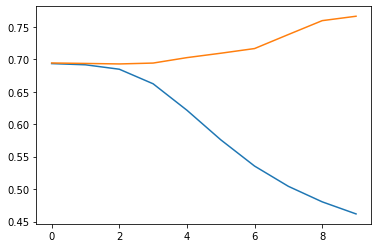

In [33]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.show()

In [22]:
torch.save(model.state_dict(), '/workspace/ceph_data/same-stance-detection/cross_topic_model_weights_new')

#### Within-topic experiment:

In [37]:
X_within_train, X_within_dev, y_within_train, y_within_dev = get_train_test_sets(within_traindev_df)

In [48]:
print('train:', len(X_within_train), 'dev:', len(X_within_dev))

train: 44732 dev: 19171


In [ ]:
x1_within_train, x2_within_train, y_within_train = process_df(X_within_train, y_within_train, passing_y=True)

In [49]:
pickle.dump(x1_within_train, open('/workspace/ceph_data/same-stance-detection/x1_within_train_new.pickle', 'wb'))
pickle.dump(x2_within_train, open('/workspace/ceph_data/same-stance-detection/x2_within_train_new.pickle', 'wb'))
pickle.dump(y_within_train, open('/workspace/ceph_data/same-stance-detection/y_within_train_new.pickle', 'wb'))

NameError: name 'x1_within_train' is not defined

In [ ]:
x1_within_dev, x2_within_dev, y_within_dev = process_df(X_within_dev, y_within_dev, passing_y=True)

In [ ]:
pickle.dump(x1_within_dev, open('/workspace/ceph_data/same-stance-detection/x1_within_dev_new.pickle', 'wb'))
pickle.dump(x2_within_dev, open('/workspace/ceph_data/same-stance-detection/x2_within_dev_new.pickle', 'wb'))
pickle.dump(y_within_dev, open('/workspace/ceph_data/same-stance-detection/y_within_dev_new.pickle', 'wb'))

In [43]:
x1_within_train = pickle.load(open('/workspace/ceph_data/same-stance-detection/x1_within_train_new.pickle', 'rb'))
x2_within_train = pickle.load(open('/workspace/ceph_data/same-stance-detection/x2_within_train_new.pickle', 'rb'))
y_within_train  = pickle.load(open('/workspace/ceph_data/same-stance-detection/y_within_train_new.pickle', 'rb'))

x1_within_dev = pickle.load(open('/workspace/ceph_data/same-stance-detection/x1_within_dev_new.pickle', 'rb'))
x2_within_dev = pickle.load(open('/workspace/ceph_data/same-stance-detection/x2_within_dev_new.pickle', 'rb'))
y_within_dev  = pickle.load(open('/workspace/ceph_data/same-stance-detection/y_within_dev_new.pickle', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/ceph_data/same-stance-detection/x1_within_train_new.pickle'

In [26]:
within_model, loss = train(10, 4096, x1_within_train, x2_within_train, y_within_train, x1_within_dev, x2_within_dev, y_within_dev)

Loaded 44732 training data.
Loaded 19171 development data.
Epoch [1/10], Iter [2796/2795] Loss: 0.6920
Accuracy of the model on the 44732.0 training images: 57.77743002772065 %%
Accuracy of the model on the 19171.0 development images: 56.57503520943091 %%
Epoch [2/10], Iter [2796/2795] Loss: 0.6858
Accuracy of the model on the 44732.0 training images: 58.64034695519986 %%
Accuracy of the model on the 19171.0 development images: 56.288143550153876 %%
Epoch [3/10], Iter [2796/2795] Loss: 0.6775
Accuracy of the model on the 44732.0 training images: 59.43172672806939 %%
Accuracy of the model on the 19171.0 development images: 56.85671065672109 %%
Epoch [4/10], Iter [2796/2795] Loss: 0.6670
Accuracy of the model on the 44732.0 training images: 62.653134221586335 %%
Accuracy of the model on the 19171.0 development images: 60.42981586771686 %%
Epoch [5/10], Iter [2796/2795] Loss: 0.6467
Accuracy of the model on the 44732.0 training images: 65.97290530269159 %%
Accuracy of the model on the 191

In [27]:
torch.save(within_model.state_dict(), '/workspace/webis20_data/same-stance-detection/within_topic_model_weights_new')

### Test Model:

#### Testing cross-topic model

In [18]:
x1_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x1_dev_new.pickle', 'rb'))
x2_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x2_dev_new.pickle', 'rb'))
y_dev  = pickle.load(open('/workspace/webis20_data/same-stance-detection/y_dev_new.pickle', 'rb'))

In [23]:
cross_test_df = within_traindev_df[within_traindev_df.tag == 'gay marriage']

In [ ]:
Loaded 1000 test data.
Accuracy of the model on the 1000.0 testing images: 50.8 %%
Loaded 1000 test data.
Accuracy of the model on the 1000.0 testing images: 53.9 %%
Loaded 1000 test data.
Accuracy of the model on the 1000.0 testing images: 51.4 %%

In [ ]:
for i in range(1, 2):
    test_sample_df = cross_test_df.sample(1000)
    x1_test, x2_test, y_test = process_df(test_sample_df, test_sample_df, passing_y=True)
    preds = test('/workspace/webis20_data/same-stance-detection/cross_topic_model_weights_new',x1_test, x2_test, y_test)

In [32]:
X_cross = cross_test_df[['argument1', 'argument2']]
#X_cross = X_cross.sample(20)
x1_test, x2_test, y_test = process_df(X_cross, passing_y=False)

RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 7.93 GiB total capacity; 6.97 GiB already allocated; 12.56 MiB free; 436.20 MiB cached)

In [ ]:
y_preds = test('/workspace/webis20_data/same-stance-detection/cross_topic_model_weights', x1_test, x2_test, y_test)

In [ ]:
#Save predictions ...
out_file = open('/workspace/webis20_data/same-stance-detection/cross_topic_test_preds_new.csv', 'w')
out_file.write('id,label\n')
for i in range(len(y_preds)):
    out_file.write('{},{} \n'.format(cross_test_df.index[i], 'True' if y_preds[i] == 1.0 else 'False'))
out_file.close()

#### Testing within-topic model

In [17]:
x1_wtihin_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x1_within_dev.pickle', 'rb'))
x2_within_dev = pickle.load(open('/workspace/webis20_data/same-stance-detection/x2_within_dev.pickle', 'rb'))
y_within_dev  = pickle.load(open('/workspace/webis20_data/same-stance-detection/y_within_dev.pickle', 'rb'))

In [18]:
preds = test('/workspace/webis20_data/same-stance-detection/within_topic_model_weights', x1_wtihin_dev, x2_within_dev, y_within_dev)

Loaded 19171 test data.
Accuracy of the model on the 19171.0 testing images: 82.37441969641647 %%


In [41]:
X_within = within_test_df[['argument1', 'argument2']]
X_within = X_within.sample(20)
x1_within_test, x2_within_test, y_within_test = process_df(X_within, passing_y=False)

In [42]:
y_preds = test('/workspace/webis20_data/same-stance-detection/within_topic_model_weights', x1_within_test, x2_within_test, y_within_test)

Loaded 20 test data.
Accuracy of the model on the 20.0 testing images: 60.0 %%


In [34]:
#Save predictions ...
out_file = open('/workspace/webis20_data/same-stance-detection/within_topic_test_preds_30k.csv', 'w')
out_file.write('id,label\n')
for i in range(len(y_preds)):
    out_file.write('{},{} \n'.format(within_test_df.index[i], 'True' if y_preds[i] == 1.0 else 'False'))
    
out_file.close()

In [35]:
ls /workspace/webis20_data/same-stance-detection/

cross_topic_model_weights            x2_dev.pickle
cross_topic_model_weights_filter     x2_dev_filter.pickle
cross_topic_test_preds.csv           x2_train.pickle
within_topic_model_weights           x2_train_filter.pickle
within_topic_model_weights_filtered  x2_within_dev.pickle
within_topic_test_preds.csv          x2_within_dev_filtered.pickle
within_topic_test_preds_10k.csv      x2_within_train.pickle
within_topic_test_preds_20k.csv      x2_within_train_filtered.pickle
within_topic_test_preds_30k.csv      y_dev.pickle
x1_dev.pickle                        y_dev_filter.pickle
x1_dev_filter.pickle                 y_train.pickle
x1_train.pickle                      y_train_filter.pickle
x1_train_filter.pickle               y_within_dev.pickle
x1_within_dev.pickle                 y_within_dev_filtered.pickle
x1_within_dev_filtered.pickle        y_within_train.pickle
x1_within_train.pickle               y_within_train_filtered.pickle
x1_within_train_filtered.pickle


In [30]:
pred_10 = list(map(lambda x: x.split(','), 
                   open('/workspace/webis20_data/same-stance-detection/within_topic_test_preds_10k.csv', 'r').read().split('\n')[1:-1]))
pred_20 = list(map(lambda x: x.split(','), 
                   open('/workspace/webis20_data/same-stance-detection/within_topic_test_preds_20k.csv', 'r').read().split('\n')[1:-1]))
pred_30 = list(map(lambda x: x.split(','), 
                   open('/workspace/webis20_data/same-stance-detection/within_topic_test_preds_30k.csv', 'r').read().split('\n')[1:-1]))

In [35]:
len(within_test_df)

31475

In [39]:
out_file = open('/workspace/webis20_data/same-stance-detection/within_topic_test_final.csv', 'w')
out_file.write('id,label\n')
for i in range(len(within_test_df)):
    if i < 10000:
        pred = pred_10[i][1].strip()
    if i >= 10000 and i < 20000:
        pred = pred_20[i-10000][1].strip()
    if i > 20000:
        pred = pred_30[i-20000][1].strip()
        
    out_file.write('{},{} \n'.format(within_test_df.index[i], pred))
    
out_file.close()